/var/folders/w0/f40yh3451y57_mt9g9mx5jmh0000gn/T/ipykernel_23412/1872190652.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')



Fire Detection Summary (2025-01-07 to 2025-01-12)
Total fires detected: 5140
Average FRP: 15.45 MW
High confidence fires: 196


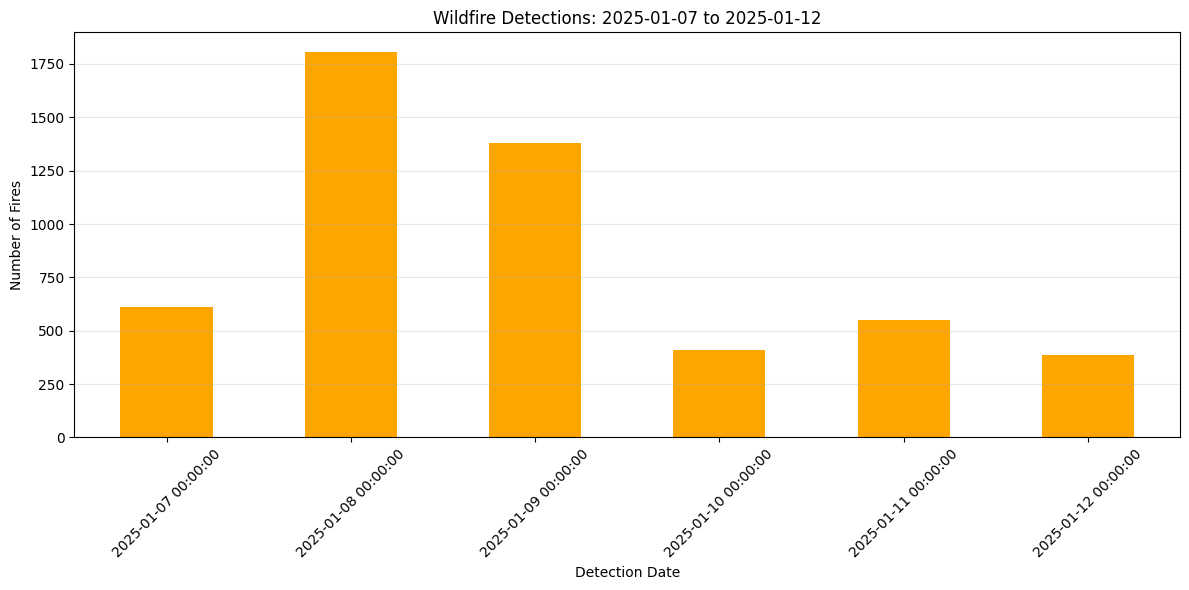

In [3]:
import geojson
import folium
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Custom date range - SET THESE VALUES
CUSTOM_START_DATE = "2025-01-07"
CUSTOM_END_DATE = "2025-01-12"

# Load and process data
with open('custom_date_fires.geojson') as f:
    data = geojson.load(f)

# Convert to DataFrame with error handling
try:
    features = data['features']
    df = pd.DataFrame([feature['properties'] for feature in features])
    df['geometry'] = [feature['geometry'] for feature in features]
except KeyError as e:
    raise ValueError("Invalid GeoJSON structure - missing 'features' key") from e

# Convert and filter dates
df['acq_date'] = pd.to_datetime(df['acq_date'])
start_date = pd.to_datetime(CUSTOM_START_DATE)
end_date = pd.to_datetime(CUSTOM_END_DATE)

# Filter by custom date range
date_mask = (df['acq_date'] >= start_date) & (df['acq_date'] <= end_date)
df_filtered = df[date_mask].copy()

# Clean data - remove rows with invalid locations
df_filtered = df_filtered.dropna(subset=['latitude', 'longitude'])

# Only create map if we have valid data
if not df_filtered.empty:
    # Calculate map center
    map_center = [
        df_filtered['latitude'].mean(),
        df_filtered['longitude'].mean()
    ]
    
    # Create map with error bounds
    m = folium.Map(
        location=map_center,
        zoom_start=4,
        tiles='CartoDB dark_matter'
    )

    # Create a color map
    cmap = cm.get_cmap('viridis')
    dates = df_filtered['acq_date'].dt.date.unique()
    colors = [cmap(i / (len(dates) - 1)) for i in range(len(dates))]
    
    # Map dates to colors
    date_colors = dict(zip(dates, colors))

    # Add markers with dynamic color
    for _, row in df_filtered.iterrows():
        if pd.notnull(row['latitude']) and pd.notnull(row['longitude']):
            date_color = date_colors.get(row['acq_date'].date(), '#ff4500')  # Default color if date not found
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=row['frp']/10,
                popup=f"""
                Date: {row['acq_date'].date()}<br>
                FRP: {row['frp']} MW<br>
                Confidence: {row['confidence']}
                """,
                color=f"#{int(date_color[0]*255):02x}{int(date_color[1]*255):02x}{int(date_color[2]*255):02x}",  # Convert RGB to HEX
                fill=True,
                fill_opacity=0.7
            ).add_to(m)
    
    # Save map
    m.save('wildfire_map.html')
else:
    print("No fire data found in specified date range")
    exit()

# Generate statistics
print(f"\nFire Detection Summary ({CUSTOM_START_DATE} to {CUSTOM_END_DATE})")
print("==============================================")
print(f"Total fires detected: {len(df_filtered)}")
print(f"Average FRP: {df_filtered['frp'].mean():.2f} MW")
print(f"High confidence fires: {len(df_filtered[df_filtered['confidence'] == 'h'])}")

# Time series analysis
daily_counts = df_filtered.groupby('acq_date').size()

plt.figure(figsize=(12, 6))
daily_counts.plot(kind='bar', color='orange')
plt.title(f'Wildfire Detections: {CUSTOM_START_DATE} to {CUSTOM_END_DATE}')
plt.xlabel('Detection Date')
plt.ylabel('Number of Fires')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('daily_fires.png', dpi=300)
